<a href="https://colab.research.google.com/github/Thejasvenan/EN3150_A03_Vision/blob/main/Vision_A03_EN3150.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
# Set seed for reproducibility

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
import kagglehub

# Download latest dataset
path = kagglehub.dataset_download("vbookshelf/rice-leaf-diseases")
print("Path to dataset files:", path)

# Dataset root folder
updated_path = os.path.join(path, 'rice_leaf_diseases')
print(os.listdir(updated_path))

# Class folders
Leaf_smut = os.path.join(updated_path, 'Leaf smut')
leaf_blight = os.path.join(updated_path, 'Bacterial leaf blight')
Brown_spot = os.path.join(updated_path, 'Brown spot')

# Check sample files
print("Leaf smut files:", os.listdir(Leaf_smut)[:5])
print("Leaf blight files:", os.listdir(leaf_blight)[:5])
print("Brown spot files:", os.listdir(Brown_spot)[:5])

Using Colab cache for faster access to the 'rice-leaf-diseases' dataset.
Path to dataset files: /kaggle/input/rice-leaf-diseases
['Brown spot', 'Bacterial leaf blight', 'Leaf smut']
Leaf smut files: ['DSC_0330.jpg', 'DSC_0313.JPG', 'DSC_0515.jpg', 'DSC_0315.jpg', 'DSC_0338.JPG']
Leaf blight files: ['DSC_0372.JPG', 'DSC_0374.JPG', 'DSC_0398.JPG', 'DSC_0396.JPG', 'DSC_0370.jpg']
Brown spot files: ['DSC_0305.JPG', 'DSC_0394.jpg', 'DSC_0105.jpg', 'DSC_0104.jpg', 'DSC_0325.JPG']


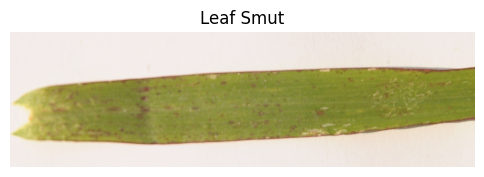

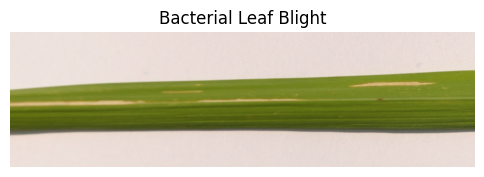

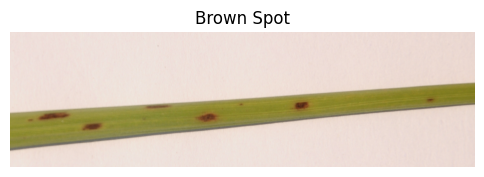

In [4]:
i = 20

Leaf_smut_1 = Image.open(os.path.join(Leaf_smut, os.listdir(Leaf_smut)[i]))
plt.figure(figsize=(6,6))
plt.imshow(Leaf_smut_1)
plt.axis('off')
plt.title("Leaf Smut")
plt.show()

leaf_blight_1 = Image.open(os.path.join(leaf_blight, os.listdir(leaf_blight)[i]))
plt.figure(figsize=(6,6))
plt.imshow(leaf_blight_1)
plt.axis('off')
plt.title("Bacterial Leaf Blight")
plt.show()

Brown_spot_1 = Image.open(os.path.join(Brown_spot, os.listdir(Brown_spot)[i]))
plt.figure(figsize=(6,6))
plt.imshow(Brown_spot_1)
plt.axis('off')
plt.title("Brown Spot")
plt.show()

In [5]:
# Split dataset into train/val/test directories

output_base = "dataset_split"

for folder in ["train", "val", "test"]:
    for cls in ["Leaf smut", "Bacterial leaf blight", "Brown spot"]:
        os.makedirs(os.path.join(output_base, folder, cls), exist_ok=True)

# Function to copy files
def split_and_copy(class_folder, class_name, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    files = os.listdir(class_folder)
    random.shuffle(files)
    n = len(files)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)

    for f in files[:n_train]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "train", class_name, f))
    for f in files[n_train:n_train+n_val]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "val", class_name, f))
    for f in files[n_train+n_val:]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "test", class_name, f))

# Split each class
split_and_copy(Leaf_smut, "Leaf smut")
split_and_copy(leaf_blight, "Bacterial leaf blight")
split_and_copy(Brown_spot, "Brown spot")


In [6]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 10

In [7]:
# Training augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Validation & test
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_base, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

val_generator = test_val_datagen.flow_from_directory(
    os.path.join(output_base, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=seed
)

test_generator = test_val_datagen.flow_from_directory(
    os.path.join(output_base, "test"),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 84 images belonging to 3 classes.
Found 18 images belonging to 3 classes.
Found 18 images belonging to 3 classes.


In [8]:
# Build CNN Model
def build_simple_cnn(input_shape=(128,128,3), num_classes=3, dropout_rate=0.5):
    model = models.Sequential()
    # First Convolutional Layer with 64 filters and a 3x3 kernel
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    # Second Convolutional Layer with 128 filters and a 3x3 kernel
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    # Third Convolutional Layer with 128 filters and a 3x3 kernel
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    # MaxPooling layer to downsample the feature maps
    model.add(layers.MaxPooling2D((2,2)))
    # Flatten & Dense
    model.add(layers.Flatten())
    # Add a dense (fully connected) layer with 256 units and ReLU activation
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    # Add the output layer with num_classes and softmax activation
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

model = build_simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=3, dropout_rate=0.5)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,612,867 (32.86 MB)

 Trainable params: 8,612,867 (32.86 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
adam_epochs = 20

# First, Adam
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_adam = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=adam_epochs
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 792ms/step - accuracy: 0.3382 - loss: 1.1048 - val_accuracy: 0.3333 - val_loss: 1.1132
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.3298 - loss: 1.1168 - val_accuracy: 0.3889 - val_loss: 1.0832
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.3538 - loss: 1.0803 - val_accuracy: 0.3333 - val_loss: 1.0803
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.3726 - loss: 1.0740 - val_accuracy: 0.7778 - val_loss: 1.0539
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.4274 - loss: 1.0807 - val_accuracy: 0.6667 - val_loss: 1.0398
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.4196 - loss: 1.0847 - val_accuracy: 0.6111 - val_loss: 0.9995
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.3937 - loss: 1.0648 - val_accuracy: 0.6111 - val_loss: 0.9594
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.5031 - loss: 1.0048 - val_accuracy: 0.7778 - val_loss

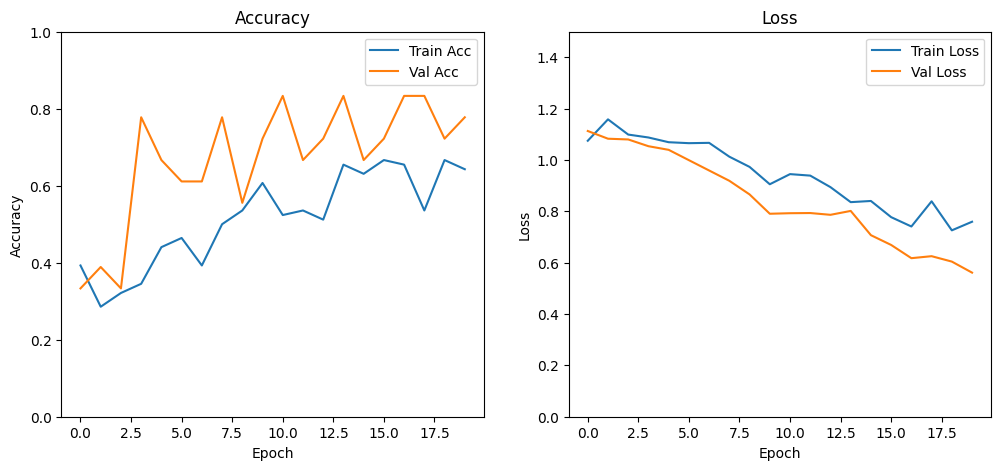

In [10]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_adam.history['accuracy'], label='Train Acc')
plt.plot(history_adam.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_adam.history['loss'], label='Train Loss')
plt.plot(history_adam.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 1.5)
plt.legend()

plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8383 - loss: 0.3854
Test Accuracy: 66.67%
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


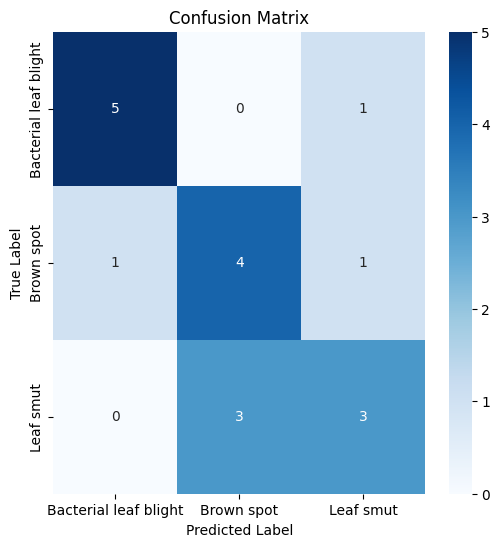

                       precision    recall  f1-score   support

Bacterial leaf blight       0.83      0.83      0.83         6
           Brown spot       0.57      0.67      0.62         6
            Leaf smut       0.60      0.50      0.55         6

             accuracy                           0.67        18
            macro avg       0.67      0.67      0.66        18
         weighted avg       0.67      0.67      0.66        18



In [11]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

In [12]:
# Using SGD
model.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_sgd = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=adam_epochs)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 579ms/step - accuracy: 0.6694 - loss: 0.6742 - val_accuracy: 0.7778 - val_loss: 0.5588
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.6361 - loss: 0.6872 - val_accuracy: 0.8333 - val_loss: 0.5574
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.7619 - loss: 0.6592 - val_accuracy: 0.8333 - val_loss: 0.5570
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.6948 - loss: 0.7143 - val_accuracy: 0.8333 - val_loss: 0.5552
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.7337 - loss: 0.6236 - val_accuracy: 0.8333 - val_loss: 0.5544
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.7679 - loss: 0.6448 - val_accuracy: 0.7778 - val_loss: 0.5500
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.7494 - loss: 0.6873 - val_accuracy: 0.7778 - val_loss: 0.5468
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.7556 - loss: 0.6101 - val_accuracy: 0.7778 - val_loss:

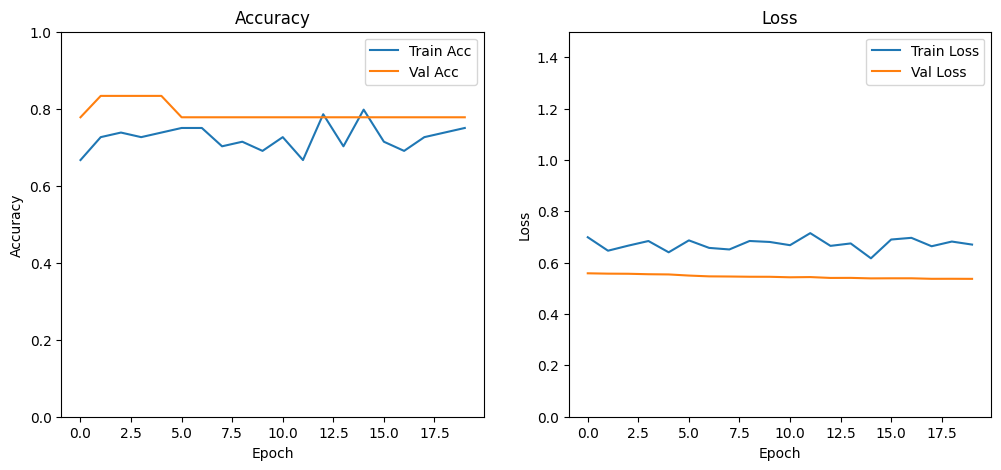

In [13]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_sgd.history['accuracy'], label='Train Acc')
plt.plot(history_sgd.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_sgd.history['loss'], label='Train Loss')
plt.plot(history_sgd.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 1.5)
plt.legend()

plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8578 - loss: 0.3905
Test Accuracy: 72.22%
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


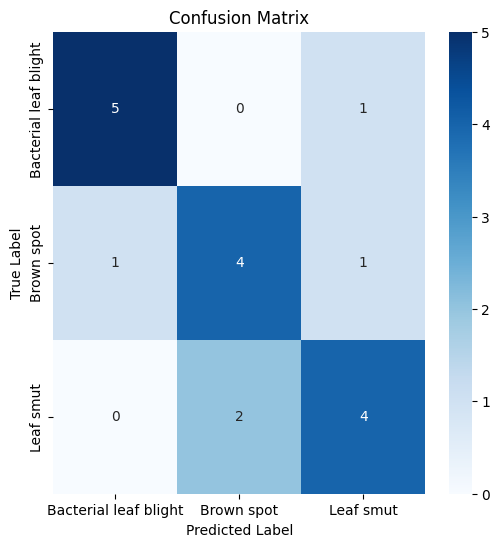

                       precision    recall  f1-score   support

Bacterial leaf blight       0.83      0.83      0.83         6
           Brown spot       0.67      0.67      0.67         6
            Leaf smut       0.67      0.67      0.67         6

             accuracy                           0.72        18
            macro avg       0.72      0.72      0.72        18
         weighted avg       0.72      0.72      0.72        18



In [14]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

In [15]:
# SGD with momentum
model.compile(optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_sgdm = model.fit(train_generator,
                         validation_data=val_generator,
                         epochs=adam_epochs)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - accuracy: 0.7266 - loss: 0.6546 - val_accuracy: 0.8333 - val_loss: 0.5459
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.7449 - loss: 0.6883 - val_accuracy: 0.7778 - val_loss: 0.5293
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.7477 - loss: 0.6363 - val_accuracy: 0.8889 - val_loss: 0.5509
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.7096 - loss: 0.6312 - val_accuracy: 0.7778 - val_loss: 0.5169
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.8179 - loss: 0.5779 - val_accuracy: 0.7778 - val_loss: 0.5119
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.7097 - loss: 0.6479 - val_accuracy: 0.8889 - val_loss: 0.5397
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.6306 - loss: 0.7186 - val_accuracy: 0.7778 - val_loss: 0.5238
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.6667 - loss: 0.6753 - val_accuracy: 0.8889 - val_loss:

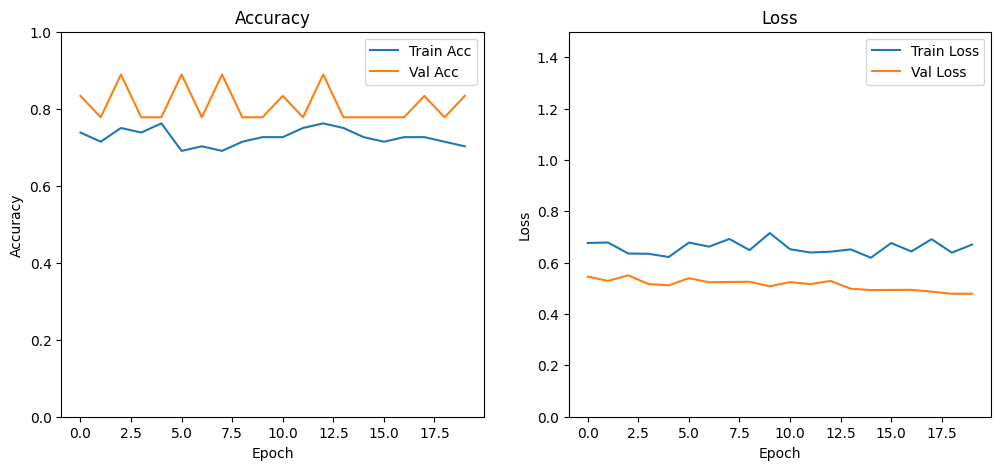

In [16]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_sgdm.history['accuracy'], label='Train Acc')
plt.plot(history_sgdm.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_sgdm.history['loss'], label='Train Loss')
plt.plot(history_sgdm.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 1.5)
plt.legend()

plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8668 - loss: 0.3263
Test Accuracy: 77.78%
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


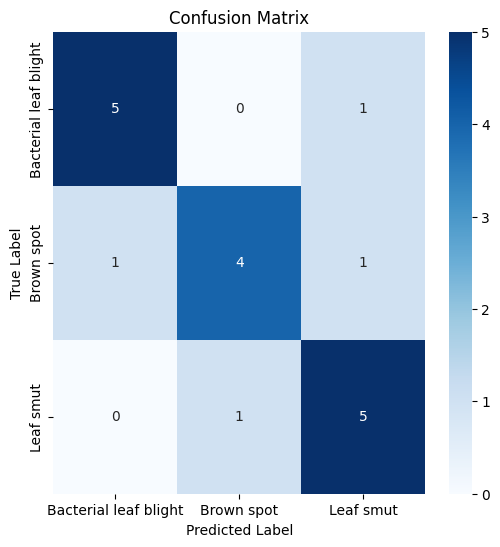

                       precision    recall  f1-score   support

Bacterial leaf blight       0.83      0.83      0.83         6
           Brown spot       0.80      0.67      0.73         6
            Leaf smut       0.71      0.83      0.77         6

             accuracy                           0.78        18
            macro avg       0.78      0.78      0.78        18
         weighted avg       0.78      0.78      0.78        18



In [17]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

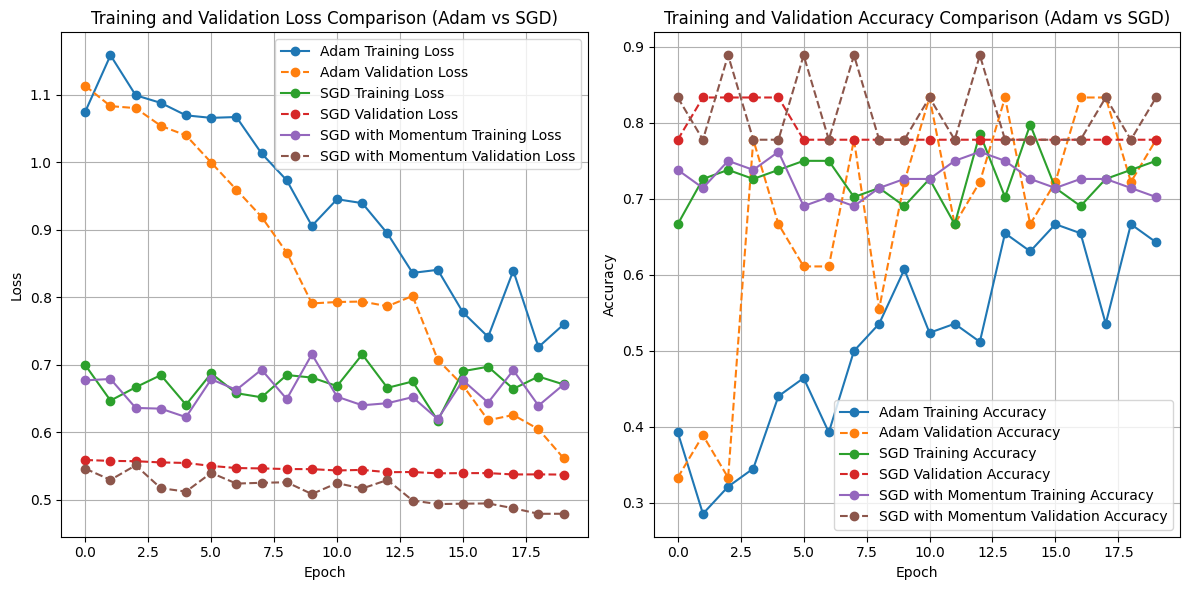

In [18]:
plt.figure(figsize=(12, 6))

# Plot Adam loss
plt.subplot(1, 2, 1)
plt.plot(history_adam.history['loss'], label='Adam Training Loss', marker='o')
plt.plot(history_adam.history['val_loss'], label='Adam Validation Loss', linestyle='--', marker='o')

# Plot SGD loss
plt.plot(history_sgd.history['loss'], label='SGD Training Loss', marker='o')
plt.plot(history_sgd.history['val_loss'], label='SGD Validation Loss', linestyle='--', marker='o')

# Plot SGD with momentum loss
plt.plot(history_sgdm.history['loss'], label='SGD with Momentum Training Loss', marker='o')
plt.plot(history_sgdm.history['val_loss'], label='SGD with Momentum Validation Loss', linestyle='--', marker='o')

plt.title('Training and Validation Loss Comparison (Adam vs SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_adam.history['accuracy'], label='Adam Training Accuracy', marker='o')
plt.plot(history_adam.history['val_accuracy'], label='Adam Validation Accuracy', linestyle='--', marker='o')

plt.plot(history_sgd.history['accuracy'], label='SGD Training Accuracy', marker='o')
plt.plot(history_sgd.history['val_accuracy'], label='SGD Validation Accuracy', linestyle='--', marker='o')

plt.plot(history_sgdm.history['accuracy'], label='SGD with Momentum Training Accuracy', marker='o')
plt.plot(history_sgdm.history['val_accuracy'], label='SGD with Momentum Validation Accuracy', linestyle='--', marker='o')


plt.title('Training and Validation Accuracy Comparison (Adam vs SGD)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

In [19]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

In [20]:
def create_data_generators(model_name, batch_size=16):
    IMG_SIZE = (224, 224)  # Standard size for pre-trained models

    if model_name == 'vgg16':
        preprocess_func = vgg_preprocess
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_func,
            rotation_range=15,
            width_shift_range=0.05,
            height_shift_range=0.05,
            zoom_range=0.1,
            horizontal_flip=True
        )
        test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)

    elif model_name == 'resnet50':
        preprocess_func = resnet_preprocess
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_func,
            rotation_range=15,
            width_shift_range=0.05,
            height_shift_range=0.05,
            zoom_range=0.1,
            horizontal_flip=True
        )
        test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        os.path.join(output_base, "train"),
        target_size=IMG_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed
    )

    val_generator = test_val_datagen.flow_from_directory(
        os.path.join(output_base, "val"),
        target_size=IMG_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed
    )

    test_generator = test_val_datagen.flow_from_directory(
        os.path.join(output_base, "test"),
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator


In [21]:
# VGG16 Model
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False,
                       input_shape=(224, 224, 3))

    # Freeze base model layers initially
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])

    return model, base_model

In [22]:
# ResNet50 Model
def create_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False,
                         input_shape=(224, 224, 3))

    # Freeze base model layers initially
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])

    return model, base_model


In [23]:
# Training function for pre-trained models
def train_pretrained_model(model_type, epochs=20, fine_tune_epochs=10):

    if model_type == 'vgg16':
        model, base_model = create_vgg16_model()
        train_gen, val_gen, test_gen = create_data_generators('vgg16')
    elif model_type == 'resnet50':
        model, base_model = create_resnet50_model()
        train_gen, val_gen, test_gen = create_data_generators('resnet50')

    # Step 1: Train only the top layers
    print(f"=== Phase 1: Training Top Layers of {model_type.upper()} ===")
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history1 = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        verbose=1
    )

    # Step 2: Fine-tune with lower learning rate
    print(f"=== Phase 2: Fine-tuning {model_type.upper()} ===")
    base_model.trainable = True

    # Fine-tune from this layer onwards
    fine_tune_at = len(base_model.layers) // 2

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001/10),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history2 = model.fit(
        train_gen,
        epochs=fine_tune_epochs,
        validation_data=val_gen,
        verbose=1
    )

   # Combine histories
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key]

    return model, combined_history, test_gen


In [24]:
# Train both models
print("Training VGG16...")
vgg_model, vgg_history, vgg_test_gen = train_pretrained_model('vgg16', epochs=15, fine_tune_epochs=10)

print("\nTraining ResNet50...")
resnet_model, resnet_history, resnet_test_gen = train_pretrained_model('resnet50', epochs=15, fine_tune_epochs=10)


Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 84 images belonging to 3 classes.
Found 18 images belonging to 3 classes.
Found 18 images belonging to 3 classes.
=== Phase 1: Training Top Layers of VGG16 ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3808 - loss: 2.8641 - val_accuracy: 0.5556 - val_loss: 2.2813
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 442ms/step - accuracy: 0.5545 - loss: 2.0044 - val_accuracy: 0.6667 - val_loss: 0.8267
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step - accuracy: 0.7706 - loss: 0.9295 - val_accuracy: 0.7222 - val_loss: 0.6952
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 380ms/step - accuracy: 0.7615 - loss: 0.6733 - val_accuracy: 0.9444 - val_loss: 0.1834
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 0.6969 - loss: 1.4026 - val_accuracy: 0.8889 - val_loss: 0.2103
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - accuracy: 0.8484 - loss: 0.4253 - val_accuracy: 1.0000 - val_loss: 0.1146
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 364ms/step - accuracy: 0.8505 - loss: 0.5762 - val_accuracy: 0.8889 - val_loss: 0.1837
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step - accuracy: 0.8681 - loss: 0.3739 - val_accuracy: 0.9444 - val_loss: 0

In [25]:
# Plot training history for both models
def plot_comparison_history(histories, model_names):
    plt.figure(figsize=(15, 5))

    for i, metric in enumerate(['accuracy', 'loss']):
        plt.subplot(1, 2, i+1)
        for history, name in zip(histories, model_names):
            if metric in history.history:
                plt.plot(history.history[metric], label=f'{name} Train')
                plt.plot(history.history[f'val_{metric}'], label=f'{name} Val', linestyle='--')

        plt.title(f'Model {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


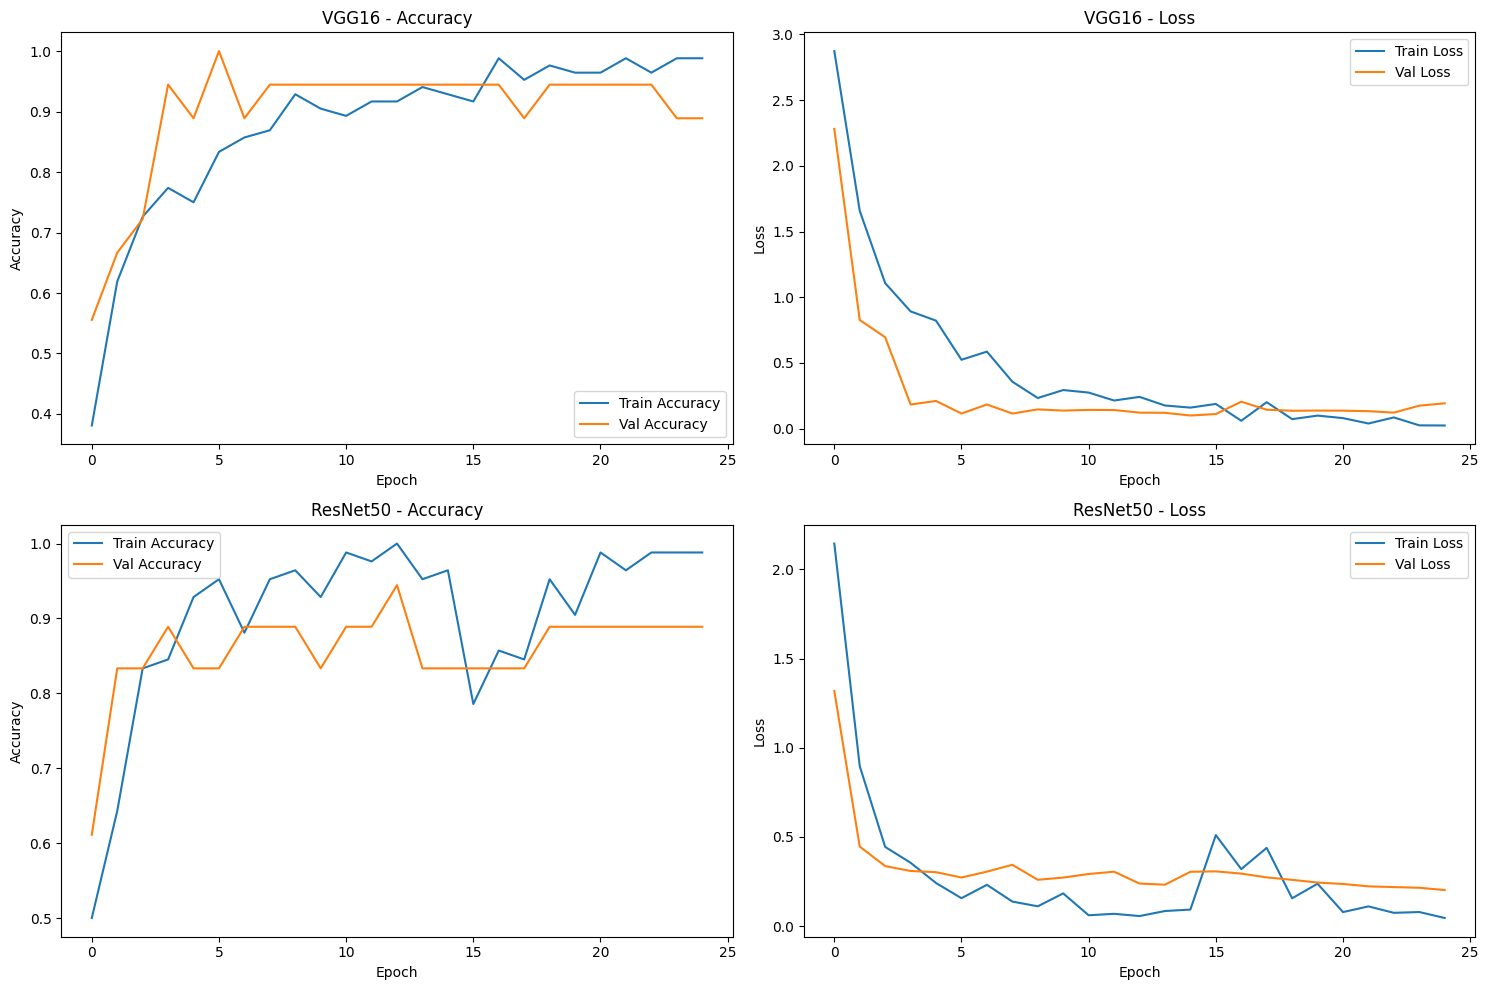

In [26]:
# Plot for pre-trained models
histories = [vgg_history, resnet_history]
model_names = ['VGG16', 'ResNet50']

plt.figure(figsize=(15, 10))
for i, (history, name) in enumerate(zip(histories, model_names)):
    plt.subplot(2, 2, i*2+1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, i*2+2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

In [27]:
def evaluate_model(model, test_generator, model_name):
    print(f"\n=== {model_name} Evaluation ===")

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

    # Predictions
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = test_generator.classes

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification Report
    print(f"\n{classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())}")

    return test_acc, test_loss, y_pred, y_true



=== VGG16 Evaluation ===
Test Accuracy: 94.44%
Test Loss: 0.1168
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


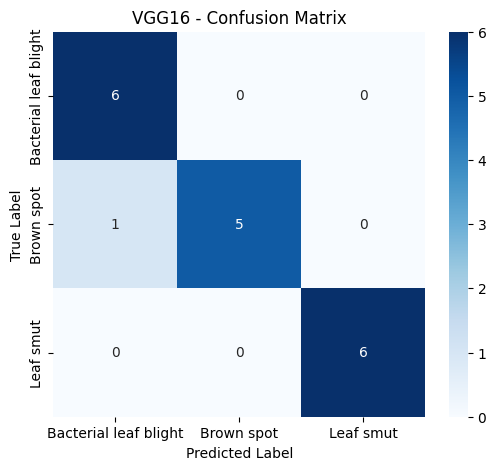


                       precision    recall  f1-score   support

Bacterial leaf blight       0.86      1.00      0.92         6
           Brown spot       1.00      0.83      0.91         6
            Leaf smut       1.00      1.00      1.00         6

             accuracy                           0.94        18
            macro avg       0.95      0.94      0.94        18
         weighted avg       0.95      0.94      0.94        18


=== ResNet50 Evaluation ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy: 94.44%
Test Loss: 0.1816
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


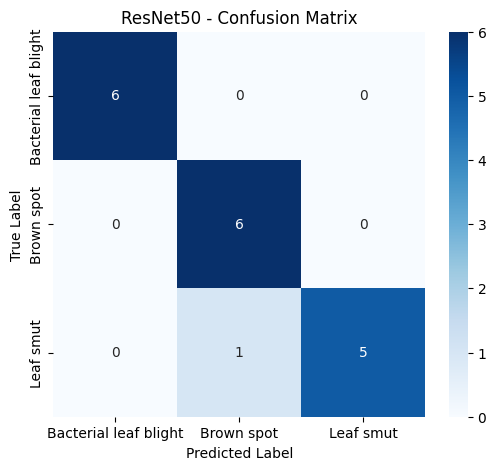


                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00         6
           Brown spot       0.86      1.00      0.92         6
            Leaf smut       1.00      0.83      0.91         6

             accuracy                           0.94        18
            macro avg       0.95      0.94      0.94        18
         weighted avg       0.95      0.94      0.94        18



In [28]:

# Evaluate VGG16
vgg_acc, vgg_loss, vgg_y_pred, vgg_y_true = evaluate_model(vgg_model, vgg_test_gen, "VGG16")

# Evaluate ResNet50
resnet_acc, resnet_loss, resnet_y_pred, resnet_y_true = evaluate_model(resnet_model, resnet_test_gen, "ResNet50")

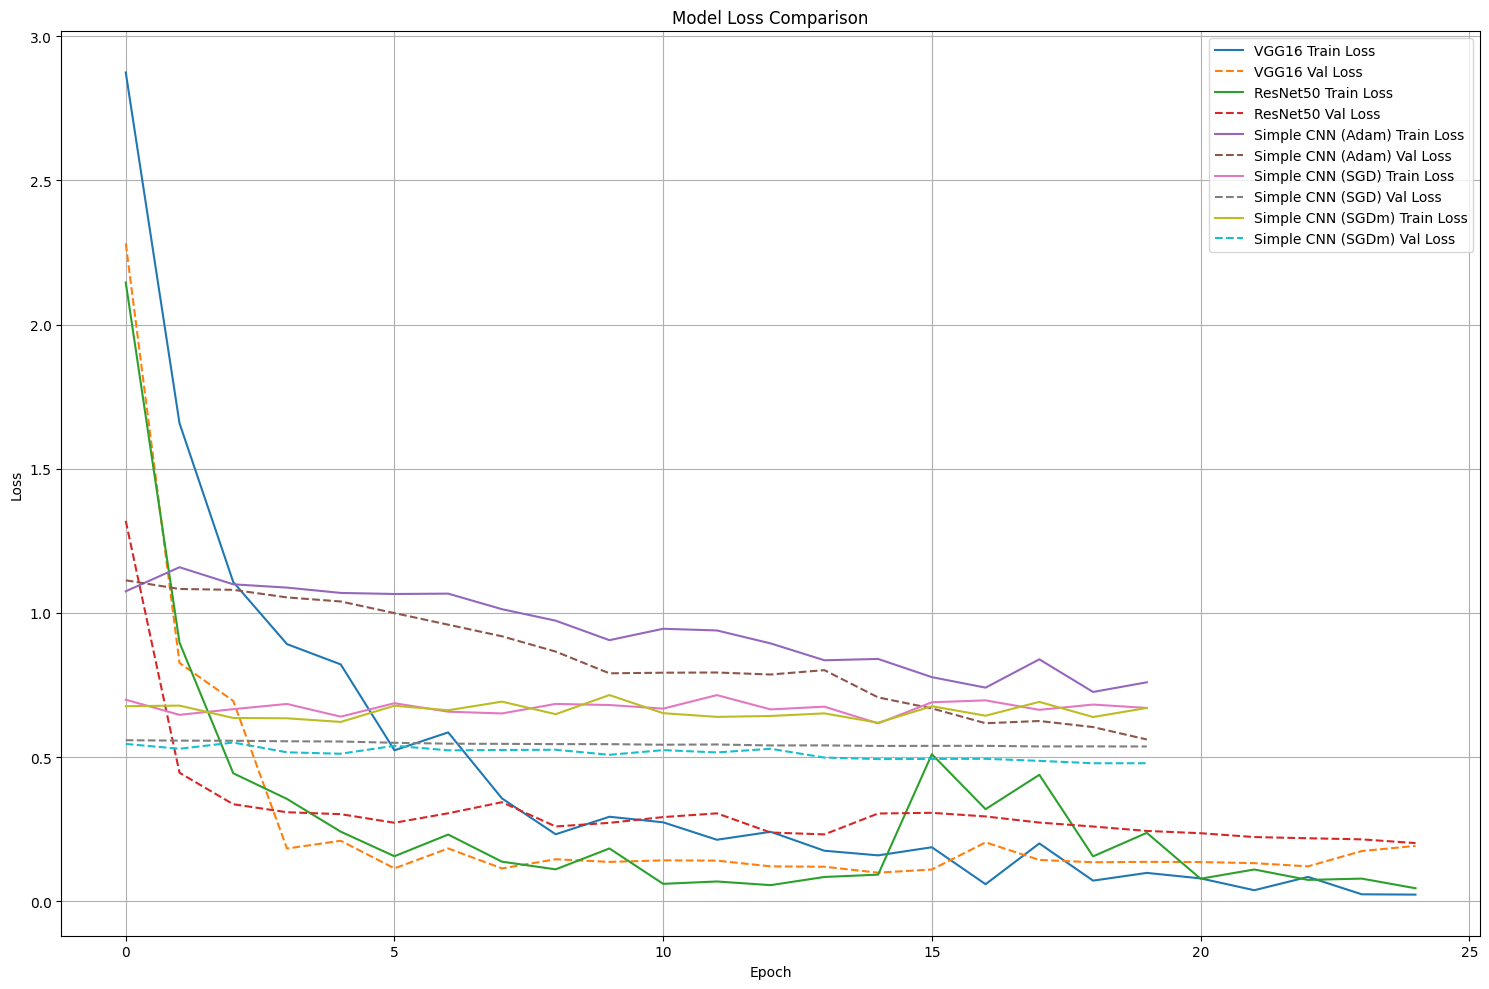

In [29]:
# Plot for pre-trained models and simple CNNs
histories = [vgg_history, resnet_history, history_adam, history_sgd, history_sgdm]
model_names = ['VGG16', 'ResNet50', 'Simple CNN (Adam)', 'Simple CNN (SGD)', 'Simple CNN (SGDm)']

plt.figure(figsize=(15, 10))
for i, (history, name) in enumerate(zip(histories, model_names)):
    # Access history data correctly for Keras History objects and dictionaries
    if isinstance(history, tf.keras.callbacks.History):
        history_data = history.history
    else:
        history_data = history

    # Only plot loss for all models together
    plt.subplot(1, 1, 1) # Use a single subplot for all loss curves
    if 'loss' in history_data:
        plt.plot(history_data['loss'], label=f'{name} Train Loss')
        plt.plot(history_data['val_loss'], label=f'{name} Val Loss', linestyle='--')

plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()